In [4]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from fredapi import Fred
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from model_class.prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

# Params

In [5]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 60
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [6]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')
ret_price = create_return(price, [1])
ret_price = ret_price.groupby('permno').shift(-1)

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = fund_q.groupby('permno').shift(3)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

# Factors

In [7]:
accrual = PrepFactor(live=live, factor_name='factor_accrual', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
accrual = accrual.groupby('permno').shift(3)
comp_debt = PrepFactor(live=live, factor_name='factor_comp_debt', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
comp_debt = comp_debt.groupby('permno').shift(3)
inv_growth = PrepFactor(live=live, factor_name='factor_inv_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
inv_growth = inv_growth.groupby('permno').shift(3)
pcttoacc = PrepFactor(live=live, factor_name='factor_pcttotacc', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
pcttoacc = pcttoacc.groupby('permno').shift(3)
asset_growth = PrepFactor(live=live, factor_name='factor_asset_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
asset_growth = asset_growth.groupby('permno').shift(3)
chtax = PrepFactor(live=live, factor_name='factor_chtax', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
chtax = chtax.groupby('permno').shift(3)
net_debt_finance = PrepFactor(live=live, factor_name='factor_net_debt_finance', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
net_debt_finance = net_debt_finance.groupby('permno').shift(3)
noa = PrepFactor(live=live, factor_name='factor_noa', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
noa = noa.groupby('permno').shift(3)
invest_ppe = PrepFactor(live=live, factor_name='factor_invest_ppe_inv', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
invest_ppe = invest_ppe.groupby('permno').shift(3)
cheq = PrepFactor(live=live, factor_name='factor_cheq', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
cheq = cheq.groupby('permno').shift(3)
xfin = PrepFactor(live=live, factor_name='factor_xfin', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
xfin = xfin.groupby('permno').shift(3)
emmult = PrepFactor(live=live, factor_name='factor_emmult', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
emmult = emmult.groupby('permno').shift(3)
grcapx = PrepFactor(live=live, factor_name='factor_grcapx', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
grcapx = grcapx.groupby('permno').shift(3)

Creating factor_accrual ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_comp_debt ---------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_inv_growth --------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_pcttotacc ---------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_asset_growth ------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_chtax -------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_net_debt_finance --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_noa ---------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_invest_ppe_inv ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_cheq --------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_xfin --------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_emmult ------------------------------------- | ✔


In [8]:
int_mom = PrepFactor(live=live, factor_name='factor_int_mom', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season = PrepFactor(live=live, factor_name='factor_mom_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ret_comp = PrepFactor(live=live, factor_name='factor_ret_comp', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()
sb_sector = PrepFactor(live=live, factor_name='factor_sb_sector', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_int_mom ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_mom_season --------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_ret_comp ----------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_sb_sector ---------------------------------- | ✔
Shape: (3104852, 32)


In [9]:
sb_pca = PrepFactor(live=live, factor_name='factor_sb_pca', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_sb_pca ------------------------------------- | ✔
Shape: (3104852, 24)


In [10]:
mom_season_short = PrepFactor(live=live, factor_name='factor_mom_season_short', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_vol = PrepFactor(live=live, factor_name='factor_mom_vol', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_off_season = PrepFactor(live=live, factor_name='factor_mom_off_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season6 = PrepFactor(live=live, factor_name='factor_mom_season6', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season11 = PrepFactor(live=live, factor_name='factor_mom_season11', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_mom_season_short --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_vol ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_mom_off_season ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season6 -------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season11 ------------------------------- | ✔
Shape: (3104852, 1)


In [11]:
load_ret = PrepFactor(live=live, factor_name='factor_load_ret', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
load_volume = PrepFactor(live=live, factor_name='factor_load_volume', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_load_ret ----------------------------------- | ✔
Shape: (3105599, 5)
Creating factor_load_volume -------------------------------- | ✔
Shape: (3105513, 5)


In [12]:
ind_mom = PrepFactor(live=live, factor_name='factor_ind_mom', group='permno', interval='D', kind='ind', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ind_mom_fama = PrepFactor(live=live, factor_name='factor_ind_mom_fama', group='permno', interval='D', kind='ind', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ind_mom_sub = PrepFactor(live=live, factor_name='factor_ind_mom_sub', group='permno', interval='D', kind='ind', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_ind_mom ------------------------------------ | ✔
Shape: (3104852, 5)
Creating factor_ind_mom_fama ------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_ind_mom_sub -------------------------------- | ✔
Shape: (3104852, 5)


# Setting Up Data

In [13]:
factor = (pd.merge(ret_price, sb_sector, left_index=True, right_index=True, how='left')
          .merge(sb_pca, left_index=True, right_index=True, how='left')
          .merge(accrual, left_index=True, right_index=True, how='left')
          .merge(comp_debt, left_index=True, right_index=True, how='left')
          .merge(ret_comp, left_index=True, right_index=True, how='left')
          .merge(inv_growth, left_index=True, right_index=True, how='left')
          .merge(pcttoacc, left_index=True, right_index=True, how='left')
          .merge(int_mom, left_index=True, right_index=True, how='left')
          .merge(mom_season, left_index=True, right_index=True, how='left')
          .merge(asset_growth, left_index=True, right_index=True, how='left')
          .merge(chtax, left_index=True, right_index=True, how='left')
          .merge(net_debt_finance, left_index=True, right_index=True, how='left')
          .merge(noa, left_index=True, right_index=True, how='left')
          .merge(invest_ppe, left_index=True, right_index=True, how='left')
          .merge(cheq, left_index=True, right_index=True, how='left')
          .merge(xfin, left_index=True, right_index=True, how='left')
          .merge(emmult, left_index=True, right_index=True, how='left')
          .merge(grcapx, left_index=True, right_index=True, how='left')
          .merge(mom_season_short, left_index=True, right_index=True, how='left')
          .merge(mom_off_season, left_index=True, right_index=True, how='left')
          .merge(mom_season6, left_index=True, right_index=True, how='left')
          .merge(mom_season11, left_index=True, right_index=True, how='left')
          .merge(load_ret, left_index=True, right_index=True, how='left')
          .merge(load_volume, left_index=True, right_index=True, how='left')
          .merge(ind_mom, left_index=True, right_index=True, how='left')
          .merge(ind_mom_fama, left_index=True, right_index=True, how='left')
          .merge(ind_mom_sub, left_index=True, right_index=True, how='left'))

In [14]:
factor['accruals'] = factor.groupby('permno')['accruals'].ffill()
factor['comp_debt_iss'] = factor.groupby('permno')['comp_debt_iss'].ffill()
factor['inv_growth'] = factor.groupby('permno')['inv_growth'].ffill()
factor['asset_growth'] = factor.groupby('permno')['asset_growth'].ffill()
factor['chtax'] = factor.groupby('permno')['chtax'].ffill()
factor['net_debt_fin'] = factor.groupby('permno')['net_debt_fin'].ffill()
factor['noa'] = factor.groupby('permno')['noa'].ffill()
factor['invest_ppe_inv'] = factor.groupby('permno')['invest_ppe_inv'].ffill()
factor['cheq'] = factor.groupby('permno')['cheq'].ffill()
factor['pct_tot_acc'] = factor.groupby('permno')['pct_tot_acc'].ffill()
factor['xfin'] = factor.groupby('permno')['xfin'].ffill()
factor['emmult'] = factor.groupby('permno')['emmult'].ffill()
factor['grcapx'] = factor.groupby('permno')['grcapx'].ffill()
factor['grcapx1y'] = factor.groupby('permno')['grcapx1y'].ffill()
factor['grcapx3y'] = factor.groupby('permno')['grcapx3y'].ffill()

In [15]:
# Add market_cap
market = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
factor = factor.merge(market, left_index=True, right_index=True, how='left')

#### Basic Fundamentals

In [16]:
fund_q['current_ratio'] = fund_q['atq'] / fund_q['lctq']
fund_q['cash_ratio'] = fund_q['cheq'] / fund_q['lctq']
fund_q['debt_equity_ratio'] = fund_q['ltq'] / fund_q['ceqq']
fund_q['return_on_assets'] = fund_q['niq'] / fund_q['atq']
fund_q['return_on_equity'] = fund_q['niq'] / fund_q['ceqq']
fund_q['gross_profit_margin'] = (fund_q['saleq'] - fund_q['cogsq']) / fund_q['saleq']
fund_q['net_profit_margin'] = fund_q['niq'] / fund_q['saleq']
fund_q['asset_turnover'] = fund_q['saleq'] / fund_q['atq']
fund_q['inventory_turnover'] = fund_q['cogsq'] / fund_q['invtq']
fund_q['payable_turnover'] = fund_q['cogsq'] / fund_q['apq']
fund_q['book_to_market'] = fund_q['ceqq'] / (fund_q['prccq'] * fund_q['cshoq'])
fund_q['price_to_earnings'] = fund_q['prccq'] / (fund_q['niq'] / fund_q['cshoq'])
fund_q['ev_to_ebitda'] = (fund_q['ltq'] + fund_q['ceqq'] + (fund_q['prccq'] * fund_q['cshoq'])) / (fund_q['niq'] + fund_q['dpq'] + fund_q['xintq'])
fund_q['debt_ratio'] = fund_q['ltq'] / fund_q['atq']
fund_q['roic'] = fund_q['niq'] / (fund_q['ceqq'] + fund_q['ltq'])
fund_q['financial_leverage'] = fund_q['atq'] / fund_q['ceqq']
fund_q['net_margin'] = fund_q['niq'] / fund_q['revtq']
fund_q['interest_coverage_ratio'] = fund_q['piq'] / fund_q['xintq']
fund_q['days_of_inventory_on_hand'] = 365 / fund_q['inventory_turnover']
fund_q['days_of_payables_outstanding'] = 365 / fund_q['payable_turnover']
fund_q = fund_q.replace([np.inf, -np.inf], np.nan)
fund_factor = fund_q[fund_q.columns[68:]]

In [17]:
factor = factor.merge(fund_factor, left_index=True, right_index=True, how='left')

# Factor Portfolios

In [18]:
# Function to select top and bottom stocks
def select_long_short_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    # return pd.concat([top_stocks])
    return pd.concat([top_stocks, bottom_stocks])

# Create Factor-Based Portfolio
def create_factor_port(data, factors, threshold):
    df = data.copy(deep=True)
    # Filtering by Market Capitalization
    df = df[df['market_cap'] >= threshold]
    # Create ranks for each factor
    print("-"*60)
    print("Creating Factor Ranks...")
    for factor_name in factors:
        print(f'Factor: {factor_name}')
        df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)
    # Calculating average rank
    df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)
    # Calculating rank weights
    df['rank_weight'] = (1 / len(factors)) * df['avg_rank']
    # Calculating inverse volatility
    df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
    df['inv_vol_weight'] = 1 / df['vol']
    # Find adjusted weight that accounts for rank and inverse volatility
    df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']
    # Selecting Top and Bottom Stocks
    print("-"*60)
    print("Creating Long/Short portfolio...")
    top_bottom_stocks = df.groupby('date').apply(select_long_short_stocks).reset_index(level=0, drop=True)
    # Normalizing Weights
    top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
    top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']
    total_ret = top_bottom_stocks.groupby('date').total_ret.sum()
    qs.reports.full(total_ret, 'SPY')
    return top_bottom_stocks

In [19]:
factor.columns[50:]

Index(['ALPHA_ret_pca_01_126', 'PCA_Return_1_ret_pca_01_126',
       'PCA_Return_2_ret_pca_01_126', 'PCA_Return_3_ret_pca_01_126',
       'PCA_Return_4_ret_pca_01_126', 'PCA_Return_5_ret_pca_01_126',
       'epsil_ret_pca_01_126', 'pred_ret_pca_01_126',
       'resid_mom_21_ret_pca_01_126', 'resid_mom_126_ret_pca_01_126',
       'idio_vol_21_ret_pca_01_126', 'idio_vol_126_ret_pca_01_126', 'accruals',
       'comp_debt_iss', 'ret_comp_1', 'ret_comp_5', 'ret_comp_21',
       'ret_comp_126', 'ret_comp_252', 'inv_growth', 'pct_tot_acc', 'int_mom',
       'mom_season', 'asset_growth', 'chtax', 'net_debt_fin', 'noa',
       'invest_ppe_inv', 'cheq', 'xfin', 'emmult', 'grcapx', 'grcapx1y',
       'grcapx3y', 'mom_season_short', 'mom_off_season', 'mom_season_6',
       'mom_season_11', 'load_ret_1', 'load_ret_2', 'load_ret_3', 'load_ret_4',
       'load_ret_5', 'load_volume_1', 'load_volume_2', 'load_volume_3',
       'load_volume_4', 'load_volume_5', 'ind_mom_01', 'ind_mom_05',
       'ind_mo

# Combine

------------------------------------------------------------
Creating Factor Ranks...
Factor: XLB_RET_01_sector_01_126
Factor: XLE_RET_01_sector_01_126
Factor: XLF_RET_01_sector_01_126
Factor: XLI_RET_01_sector_01_126
Factor: XLK_RET_01_sector_01_126
Factor: XLP_RET_01_sector_01_126
Factor: XLU_RET_01_sector_01_126
Factor: XLV_RET_01_sector_01_126
Factor: XLY_RET_01_sector_01_126
Factor: PCA_Return_1_ret_pca_01_126
Factor: PCA_Return_2_ret_pca_01_126
Factor: PCA_Return_3_ret_pca_01_126
Factor: PCA_Return_4_ret_pca_01_126
Factor: PCA_Return_5_ret_pca_01_126
Factor: accruals
Factor: inv_growth
Factor: comp_debt_iss
Factor: pct_tot_acc
Factor: chtax
Factor: net_debt_fin
Factor: noa
Factor: invest_ppe_inv
Factor: cheq
Factor: xfin
Factor: emmult
Factor: grcapx
Factor: ev_to_ebitda
Factor: load_ret_1
Factor: load_ret_2
Factor: load_ret_3
Factor: load_ret_4
Factor: load_ret_5
Factor: mom_season
Factor: mom_season_short
Factor: mom_season_6
----------------------------------------------------

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-03-01   2005-03-01
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          265.26%      465.9%
CAGR﹪                     4.9%         6.61%

Sharpe                     0.45         1.4
Prob. Sharpe Ratio         97.48%       100.0%
Smart Sharpe               0.45         1.38
Sortino                    0.64         2.01
Smart Sortino              0.63         1.98
Sortino/√2                 0.45         1.42
Smart Sortino/√2           0.44         1.4
Omega                      1.28         1.28

Max Drawdown               -56.47%      -35.8%
Longest DD Days            1982         1965
Volatility (ann.)          19.47%       6.81%
R^2                        0.01         0.01
Information Ratio          0.0          0.0
Calmar                  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-06-01,2009-06-15,2012-10-16,1965,-35.798757,-35.157545
2,2020-03-10,2020-03-24,2020-04-14,36,-9.234844,-8.738509
3,2020-09-09,2021-01-28,2021-04-16,220,-8.066757,-7.984761
4,2005-08-15,2005-10-26,2006-03-10,208,-6.205534,-5.756793
5,2020-04-16,2020-06-05,2020-08-19,126,-5.919492,-5.715373


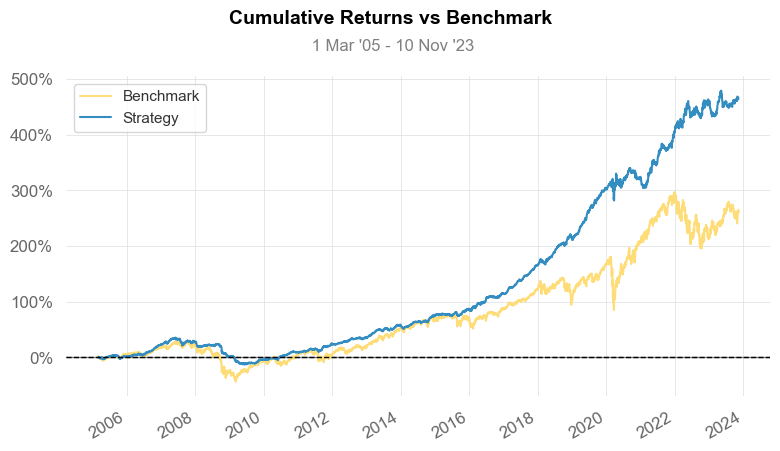

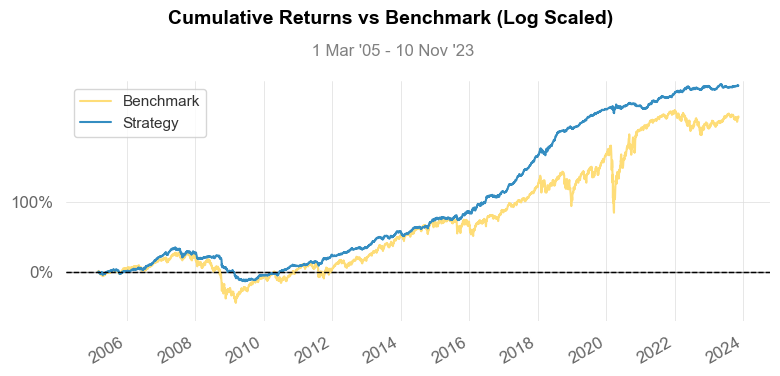

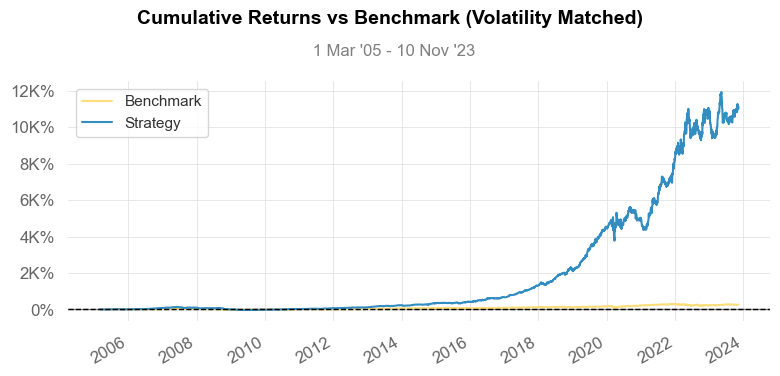

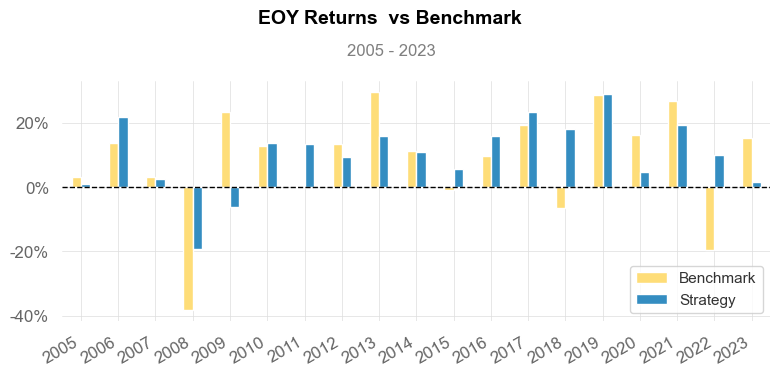

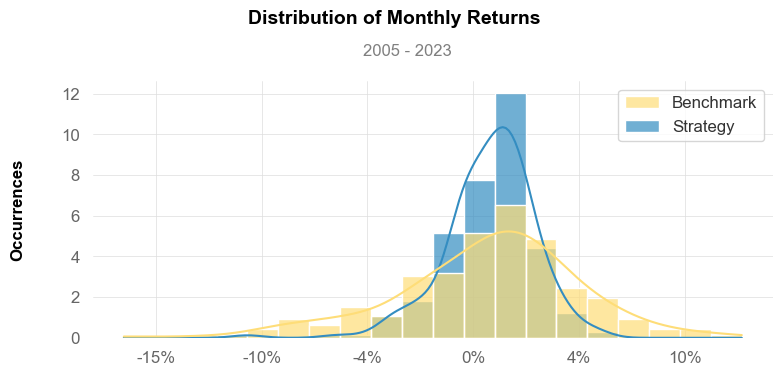

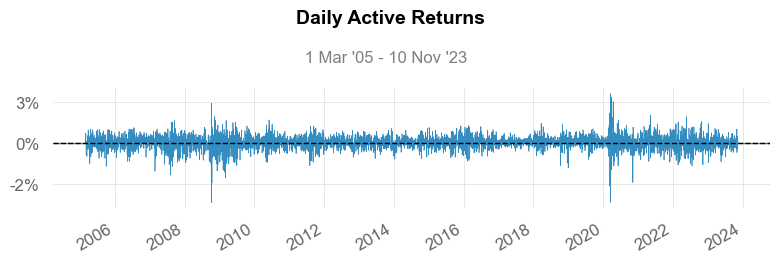

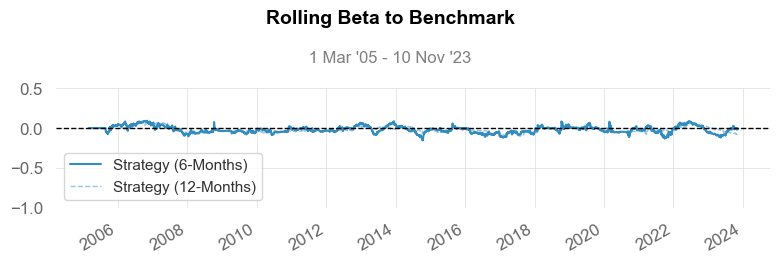

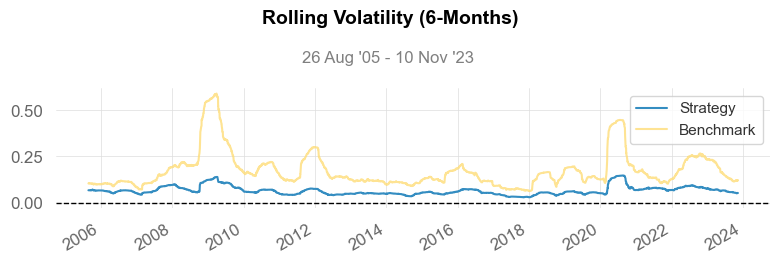

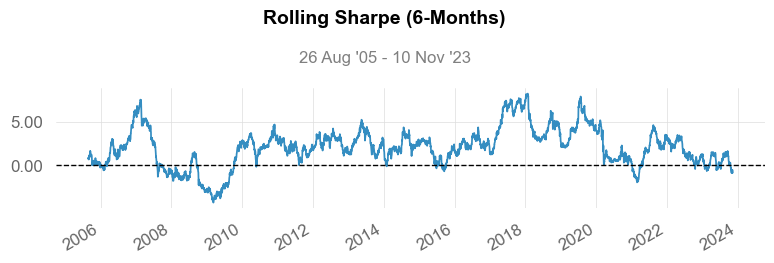

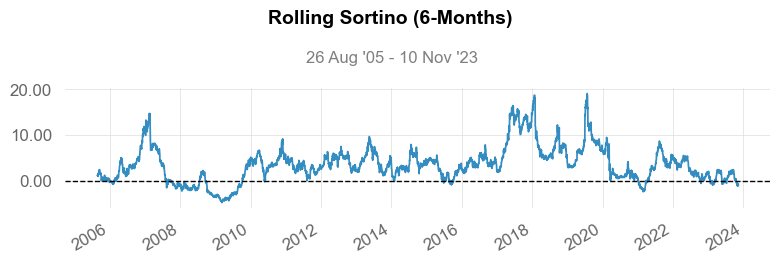

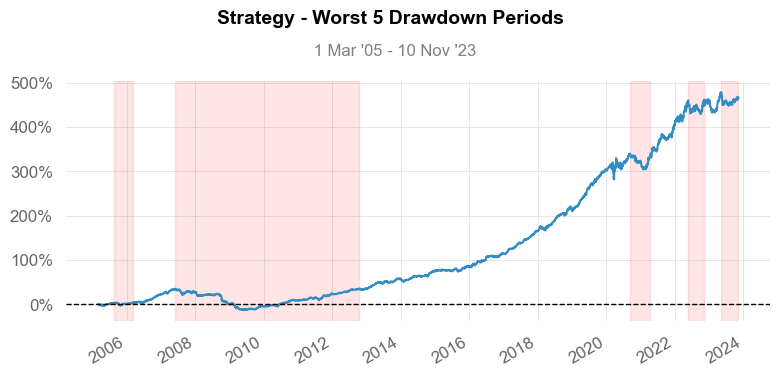

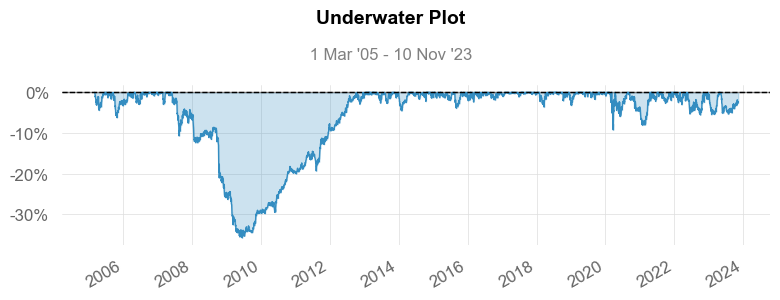

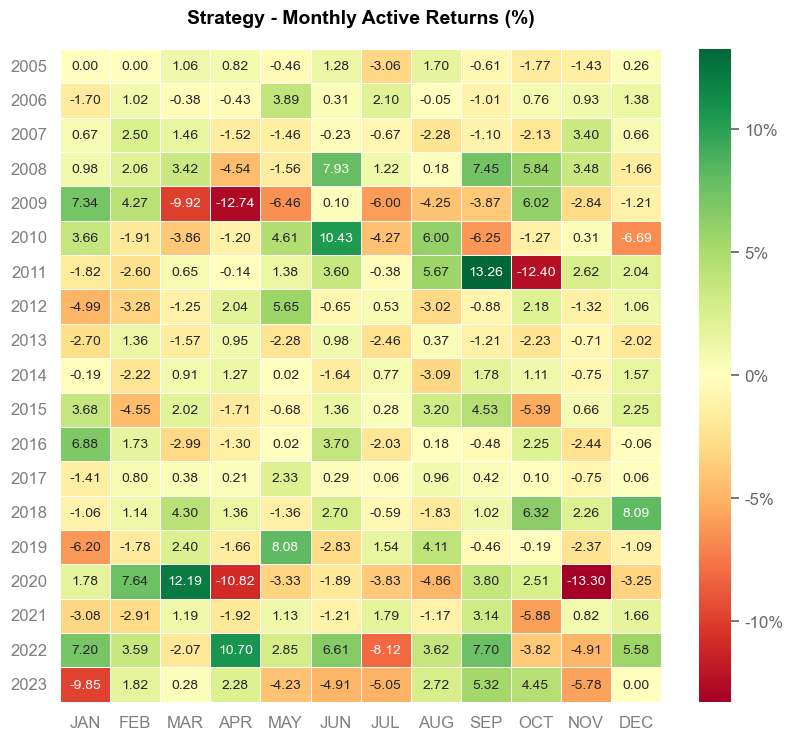

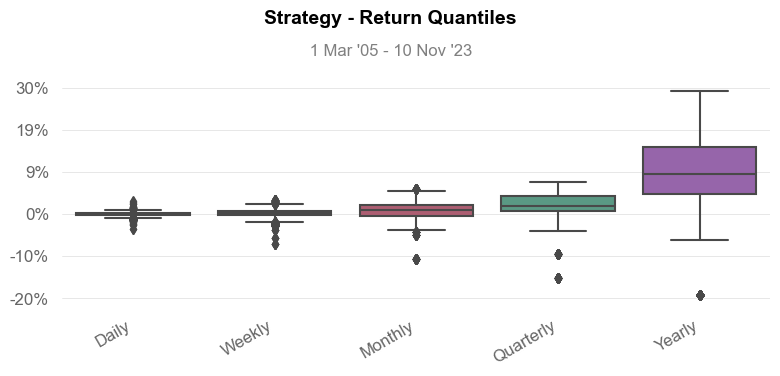

In [20]:
factors = [
    "XLB_RET_01_sector_01_126",
    "XLE_RET_01_sector_01_126",
    "XLF_RET_01_sector_01_126",
    "XLI_RET_01_sector_01_126",
    "XLK_RET_01_sector_01_126",
    "XLP_RET_01_sector_01_126",
    "XLU_RET_01_sector_01_126",
    "XLV_RET_01_sector_01_126",
    "XLY_RET_01_sector_01_126",
    'PCA_Return_1_ret_pca_01_126',
    'PCA_Return_2_ret_pca_01_126', 
    'PCA_Return_3_ret_pca_01_126',
    'PCA_Return_4_ret_pca_01_126', 
    'PCA_Return_5_ret_pca_01_126',
    "accruals",
    "inv_growth",
    "comp_debt_iss",
    "pct_tot_acc",
    'chtax', 
    'net_debt_fin', 
    'noa',
    'invest_ppe_inv', 
    'cheq', 
    'xfin', 
    'emmult', 
    'grcapx',
    'ev_to_ebitda',
    'load_ret_1', 
    'load_ret_2', 
    'load_ret_3', 
    'load_ret_4',
    'load_ret_5',
    "mom_season",
    "mom_season_short",
    "mom_season_6"
]

total_ret = create_factor_port(factor, factors, threshold)

In [24]:
total_ret.loc[total_ret.index.get_level_values('date') == '2023-11-09']

,,Open,High,Low,Close,Volume,RET_01,ALPHA_sector_01_21,XLB_RET_01_sector_01_21,XLE_RET_01_sector_01_21,XLF_RET_01_sector_01_21,...,mom_season_Rank,mom_season_short_Rank,mom_season_6_Rank,avg_rank,rank_weight,vol,inv_vol_weight,adj_weight,final_weight,total_ret
permno,date,,,,,,,,,,,,,,,,,,,,,
13379,2023-11-09,146.600,147.150,146.4650,147.00,1424646.0,0.003071,-0.000215,-0.219289,0.040243,0.082177,...,1.0,302.0,64.0,350.132353,10.003782,0.002134,468.593770,4687.709697,0.130395,0.000400
88949,2023-11-09,213.300,214.380,212.7500,213.72,1415766.0,0.003663,0.000306,-0.152241,0.054073,-0.329307,...,113.0,377.0,285.0,333.397059,9.525630,0.003793,263.643035,2511.366070,0.069857,0.000256
13618,2023-11-09,35.460,35.505,35.0700,35.16,2231337.0,-0.003684,0.000476,0.040472,0.296132,0.583361,...,86.0,457.0,442.0,303.457143,8.670204,0.006533,153.060073,1327.062070,0.036914,-0.000136
55976,2023-11-09,164.550,166.440,163.9000,166.19,4773461.0,0.013848,0.000223,-0.401635,0.085657,-0.047853,...,460.0,312.0,350.0,333.600000,9.531429,0.007715,129.618297,1235.447542,0.034366,0.000476
43449,2023-11-09,267.330,268.125,265.2100,267.79,2664866.0,0.003297,0.001902,0.682912,0.197755,-1.150627,...,357.0,425.0,431.0,352.542857,10.072653,0.008300,120.484531,1213.598877,0.033758,0.000111
88233,2023-11-09,93.530,93.660,92.4100,93.54,1087338.0,0.003325,-0.005684,-0.170134,-0.417425,0.238572,...,402.0,202.0,283.0,382.705882,10.934454,0.009077,110.164758,1204.591451,0.033507,0.000111
13856,2023-11-09,167.310,167.780,164.8600,166.92,5526852.0,0.004574,-0.001254,0.173712,-0.115208,-0.393687,...,343.0,539.0,437.0,331.371429,9.467755,0.007868,127.103550,1203.385282,0.033474,0.000153
89006,2023-11-09,69.160,69.310,68.3700,69.12,7076739.0,0.002611,0.002599,0.530823,-0.079073,-0.768451,...,224.0,542.0,220.0,351.457143,10.041633,0.008839,113.135700,1136.067141,0.031601,0.000083
85348,2023-11-09,124.560,126.080,123.5950,125.95,1317194.0,0.009943,0.002371,0.957529,0.260680,-0.673658,...,431.0,572.0,555.0,366.171429,10.462041,0.009361,106.829656,1117.656220,0.031089,0.000309
